# Customer Segmentation using RFM Clustering

In this notebook, Amsel customer purchase data is analyzed across three dimensions: 
<ul>
    <li> the recency of purchases
    <li> the frequency of purchases for one year
    <li> the amount of money spent on purchases for one year
</ul>
In this analysis, the team at Amsel has hypothesized that: 
<ul>
    <li> customers can be divided into groups based on their purchase history
    <li> marketing campaigns can be more effective if they are targeted to different customer groups
</ul>

## Setup and Install the necessary packages


In [1]:
import pandas as pd
import numpy as np
import types
import datetime
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

palette = [ 'dodgerblue','plum','lightpink', 'mediumblue', 'salmon','darkcyan']


## Access available data
 
### Read the Data & convert it into a Dataframe

Click on "Insert to code" and then select "Insert pandas DataFrame" in the below empty cell.

In the output, a sample of the data is shown and the "shape" of the data (having 541,909 rows and 8 columns) is summarized. 

A customer order can span multiple rows in the data set, with each individual item in the order listed on a different line in the data set. 


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Assign a new name for the dataframe

In [3]:
'''Rename the dataframe to df'''

df = df_data_2

## Clean/Transform Data

In these steps, the data is prepared for modeling. To clean the data, rows with missing or invalid data are removed from the data set. 

The columns that will be important in the analysis are selected. Columns for "Country" and "Description" are dropped from the data set.  

For each customer, calculations are performed to identify: 

<ul>
    <li> frequency - how many purchases has the customer made over the last year? 
    <li> recency - how recently has the customer made a purchase? A value of 12 indicates the most recent month while a value of 1 indicates a purchase made one year ago. 
    <li> monetary value - how much money has the customer spent in purchases over the last year? 
</ul>

A sample of the prepared data can be seen below listing the 'R', 'F' and 'M' values for each customer. There were 3,813 unique customers in the purchase data. 


In [4]:
# Narrow the study to United Kingdom in 2011
df = df[df['Country']=='United Kingdom'].reset_index(drop=True)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df[df.apply(lambda x : x['InvoiceDate'].year == 2011, axis=1)].copy(deep=True)

# print data attributes
print ("small data shape : {} \n".format(df.shape))
print ("variables : {}".format(df.columns.tolist()))

small data shape : (455353, 8) 

variables : ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']


In [5]:
## Select variables of interest
df = df[['InvoiceNo', 'StockCode', 'Quantity', 'UnitPrice', 'InvoiceDate', 'CustomerID']].copy(deep=True)

## Create an aggregated variable named Amount
df['Amount'] = df['Quantity']*df['UnitPrice']

## Filter out any transactions that do not have a postcode (*country) associated with
df = df[df['CustomerID'].notna()]

## Filter out negative quatities -> might be items returned
df = df[df['Amount']>0].copy(deep=True)

In [6]:
## Create aggregated variables 
max_date = max(df['InvoiceDate']) + datetime.timedelta(days=1)
min_date = min(df['InvoiceDate']) - datetime.timedelta(days=1)

# Compute the Recency
def get_recency(x):
    last_purchase = x.max()
    return 12 - (max_date.month - last_purchase.month) # Inverted -> high recency = recent purchase

# Compute the time since last purchase
def get_first_purchase(x):
    first_purchase = x.min()
    return (first_purchase.month - min_date.month)

# Compute the frequency
def get_frequency(x):
    return x.nunique()


customers = df.groupby('CustomerID').agg(
    recency=('InvoiceDate', get_recency),
    frequency=('InvoiceNo', get_frequency),
    monetary=('Amount', 'sum')
)

VARIABLES = ['recency', 'frequency', 'monetary'] 

print("data shape : {}".format(customers.shape))
customers.head()

data shape : (3813, 3)


,recency,frequency,monetary
CustomerID,,,
12346.0,1,1,77183.60
12747.0,12,9,3489.74
12748.0,12,174,29491.60
12749.0,12,5,4090.88
12820.0,12,4,942.34


### Outliers and Scaling

First, the distribution for each of the features of recency, frequency and monetary value is visualized. Then, the distributions are examined again following the removal of outliers. 

In a real world case, there might be cause to perform further analysis on the outliers. 

Finally, the variables are scaled using the mean and standard deviation. For more information on scaling, see here: https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler

In [7]:
# plot the distribution of the RFM features
def dist_plot(data):
    fig = plt.figure(figsize=(10, 10))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for idx, variable in enumerate(VARIABLES):
        if variable not in ['monetary'] :
            ax = fig.add_subplot(3, 1, idx+1)
            ax.set(ylabel='Density')
            # manualy set the bins for the monetary feature
            sns.distplot(data[variable], ax=ax, bins=int(data[variable].max())+1)
        else :
            ax = fig.add_subplot(3, 1, idx+1)
            ax.set(ylabel='Density')
            sns.distplot(data[variable], ax=ax)


    plt.show()

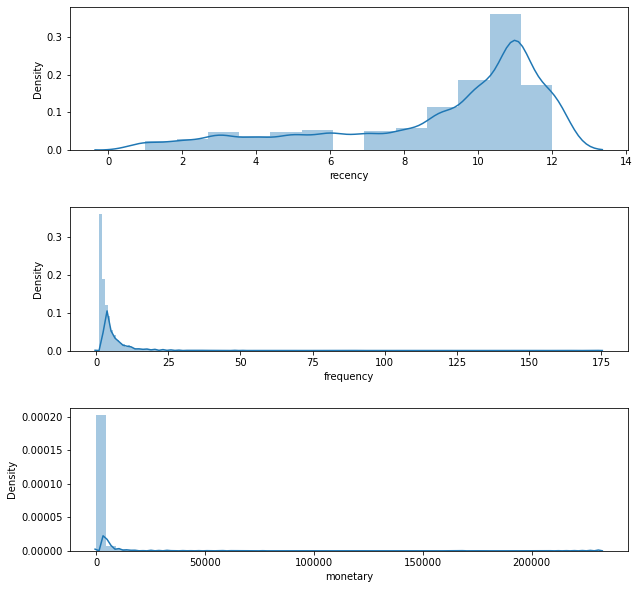

In [8]:
dist_plot(customers)

In [9]:
## Remove Outliers 

customers = customers[(customers['monetary']<15000)&(customers['frequency']<30)].copy(deep=True)

print("data shape : {}".format(customers.shape))

data shape : (3757, 3)


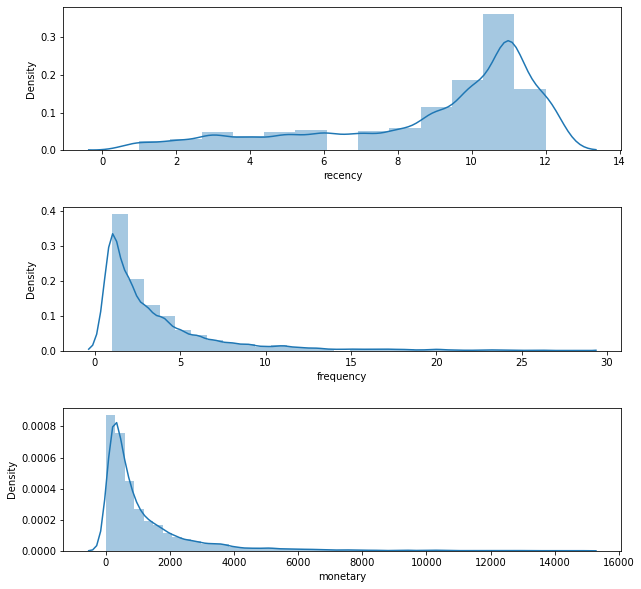

In [10]:
dist_plot(customers)

In [11]:
# Scale the RFM variables
scaler = StandardScaler()

customers_scaled = scaler.fit_transform(customers[VARIABLES])
customers_scaled = pd.DataFrame(customers_scaled, columns= VARIABLES)

## Train Models

In this example, the k-means clustering model will be used to divide the customers into groups based on their purchase history. 

The model will group customers by similarity based on the RFM factors over the previous year.

For a thorough explanation of clustering, see the IBM Training course on Unsupervised Learning here -> https://www.ibm.com/training/course/W7104G


### Elbow method - How many clusters should the data be divided into? 

In order to use the k-means clustering algorithm, we need to specify the number of clusters for the algorithm - the value for k. To do this, the k-means algorithm is fit using a range of clusters from 2 - 9. For each proposed number of clusters, the similarity of data points within each cluster is measured. In the plot below, the number of clusters is plotted against a measure of "goodness of fit" of the clustering - a measure indicating the similarity of the data points within each cluster. For a complete explanation with videos, see the training course mentioned above.   

In examining the plot, we look for a sharp bend or an "elbow" to indicate that a particular cluster number greatly improves the fit of the clustering. In our plot, cluster values of 3 and 4 occur at an "elbow bend" in the plot. 


In [12]:
# Implement Elbow method to find the most appropriate number of clusters

def Elbow(n_clusters, ci_alpha=2.576, metric='inertia'): 
    silhouettes = []
    ci_coefficients = []
    # loop on the number of cluster
    for n_cluster in n_clusters :
        print("n_cluster : {} ".format(n_cluster), end = '')
        n_iter = 30
        s_scores = []
        # perform n_iter clustering experiments with random initializations
        for _ in range(n_iter) :
            print(".", end = '')
            kmean = KMeans(n_cluster, init='random').fit(customers_scaled)
            # compute the clustering metric for each experiment
            if metric == 'inertia' :
                s_scores.append(kmean.inertia_)
            elif metric == 'silhouette' : 
                s_scores.append(silhouette_score(customers_scaled, kmean.labels_, metric='euclidean'))
            else :
                raise NameError('arg : {}  is not implemented'.format(metric))

        mean_ = np.mean(s_scores)
        std_ = np.std(s_scores)
        ci_coefficient = ci_alpha*std_/np.sqrt(n_iter)

        silhouettes.append(mean_)
        ci_coefficients.append(ci_coefficient)

        print ("    -> CI : [{}, {}]".format(mean_ + ci_coefficient, mean_ - ci_coefficient))

    ci_coefficients = np.array(ci_coefficients)
    silhouettes = np.array(silhouettes)
    return silhouettes, ci_coefficients

n_cluster : 2 ..............................    -> CI : [6545.436987465115, 6545.411334085384]
n_cluster : 3 ..............................    -> CI : [3690.844680228572, 3690.8140391372376]
n_cluster : 4 ..............................    -> CI : [2603.1027255707395, 2601.703269084276]
n_cluster : 5 ..............................    -> CI : [2149.322681695476, 2130.228756801946]
n_cluster : 6 ..............................    -> CI : [1802.0493903934794, 1799.4031890531337]
n_cluster : 7 ..............................    -> CI : [1602.196585330554, 1589.416370850833]
n_cluster : 8 ..............................    -> CI : [1453.0011742001302, 1444.328416010786]
n_cluster : 9 ..............................    -> CI : [1316.844821049919, 1312.3512157741045]


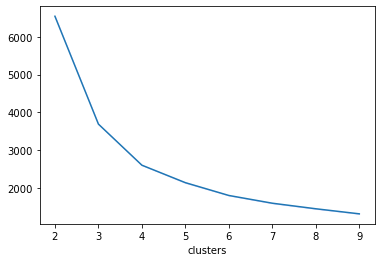

In [13]:
# plot the Elbow curve

n_clusters = np.array([2, 3, 4, 5, 6, 7, 8, 9])

silhouettes, ci = Elbow(n_clusters)

fig, ax = plt.subplots()
ax.plot(n_clusters, silhouettes)
ax.fill_between(n_clusters, (silhouettes-ci), (silhouettes+ci), color='b', alpha=.1)
ax.set(xlabel="clusters")
plt.show()

The Elbow method seems to suggest 3 or 4 clusters as a good fit.

### fit K-means

Here, the clustering model is fit to the data using 4 clusters (k = 4). In the output table, we see sample rows of the dataset labeled with a value between 0 and 3 indicating to which cluster the observation is assigned. 

In [14]:
# fit k-mean
n_cluster = 4

kmean = KMeans(n_cluster, init='k-means++', random_state=42).fit(customers_scaled)

In [15]:
labels = kmean.labels_.reshape(-1, 1)
centers = kmean.cluster_centers_

# We store the labels in a DataFrame with the RFM variables
df_cluster = pd.DataFrame(np.concatenate((customers, labels), axis=1), 
                          columns = VARIABLES + ['labels'])


print("data shape : {}".format(df_cluster.shape))
df_cluster.head()

data shape : (3757, 4)


,recency,frequency,monetary,labels
0,12.0,9.0,3489.74,1.0
1,12.0,5.0,4090.88,1.0
2,12.0,4.0,942.34,2.0
3,5.0,1.0,92.72,0.0
4,9.0,2.0,948.88,2.0


### Cluster investigation

After clustering, the clusters are examined to evaluate the result. We see the count of the number of data points in each cluster as well as descriptive statistics for each of the clusters. Examining the size of each cluster and the associated descriptive statistics helps to further evaluate the fit of the clustering and to get insight about the purchase behavior of the customers in each cluster. 

In [16]:
# Cluster distribution
sorted(Counter(df_cluster['labels']).items())

[(0.0, 919), (1.0, 639), (2.0, 2077), (3.0, 122)]

In [17]:
# Global Statistics
df_cluster[VARIABLES].describe()

,recency,frequency,monetary
count,3757.000000,3757.000000,3757.000000
mean,9.001065,3.517434,1228.873469
std,2.957995,3.712373,1699.173805
min,1.000000,1.000000,3.750000
25%,8.000000,1.000000,289.960000
50%,10.000000,2.000000,623.160000
75%,11.000000,4.000000,1479.220000
max,12.000000,28.000000,14746.630000


In [18]:
# Statistics on the clusters

cluster_groups = df_cluster.groupby('labels')

for key, item in cluster_groups:
    print("Cluster : {}".format(key))
    descr = cluster_groups.get_group(key).describe()
    print(descr.loc[["mean", "std", "min", "max"]])
    print('')

Cluster : 0.0
       recency  frequency     monetary  labels
mean  4.396083   1.482046   410.108042     0.0
std   1.883834   0.902341   408.359459     0.0
min   1.000000   1.000000     3.750000     0.0
max   7.000000   9.000000  4036.960000     0.0

Cluster : 1.0
        recency  frequency     monetary  labels
mean  10.981221   7.674491  2867.810516     1.0
std    1.021535   2.875225  1194.596717     0.0
min    5.000000   1.000000   803.900000     1.0
max   12.000000  21.000000  6933.300000     1.0

Cluster : 2.0
        recency  frequency     monetary  labels
mean  10.285026   2.363987   698.474084     2.0
std    1.145332   1.345589   521.902251     0.0
min    7.000000   1.000000     6.200000     2.0
max   12.000000   7.000000  3178.170000     2.0

Cluster : 3.0
        recency  frequency      monetary  labels
mean  11.459016  16.713115   7842.022459     3.0
std    0.717520   5.083565   2821.039029     0.0
min    8.000000   3.000000   3511.800000     3.0
max   12.000000  28.000000  14

### Cluster Visualization

Here, the clusters are plotted in 3D with axes recency, frequency and monetary. 

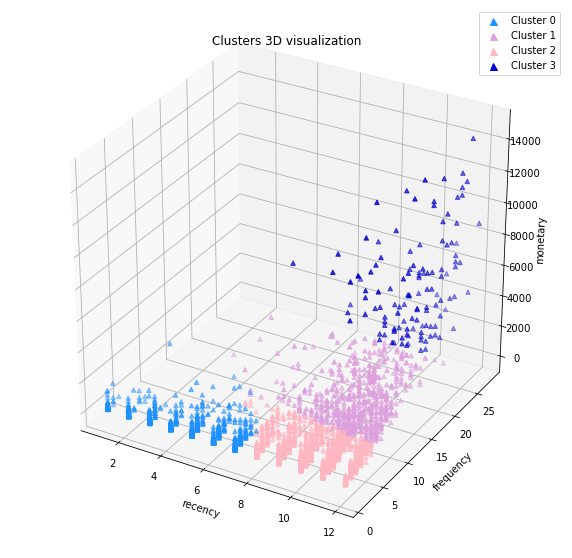

In [19]:
# 3D visualization of the clusters
fig=plt.figure(figsize=(10, 10)) 
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Clusters 3D visualization")

ax.scatter3D(df_cluster['recency'].values, 
            df_cluster['frequency'].values, 
            df_cluster['monetary'].values, 
            c=[palette[int(x)] for x in df_cluster.labels.values],
            marker= '^')

ax.set_xlabel('recency')
ax.set_ylabel('frequency')
ax.set_zlabel('monetary')

handles_lst = []
for color in palette[:4]:
    handles_lst.append(mlines.Line2D([], [], color=color, marker='^', linewidth=0,
        markersize=7, label="Cluster " + str(palette.index(color))))
    
plt.legend(handles=handles_lst)

plt.show()


Cluster 0 seems to have all the customers with low Recency. (Recall that a value of 1 for Recency indicates that the customer has not made a purchase in 12 months while a value of 12 indicates that they made a purchase within the last month.)  


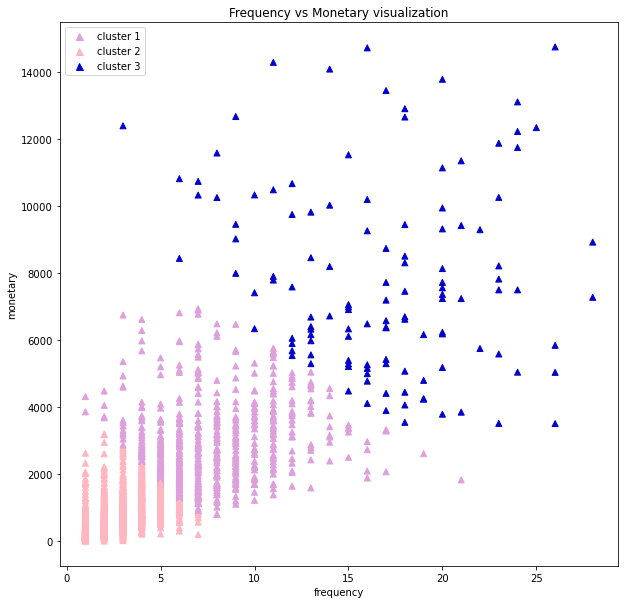

In [20]:
# filter out cluster 0 for this visualization
df_filter = df_cluster[df_cluster['labels'] != 0.0]

fig=plt.figure(figsize=(10, 10)) 
ax = fig.add_subplot(111)
ax.set_title("Frequency vs Monetary visualization")

ax.scatter( df_filter['frequency'].values, 
            df_filter['monetary'].values, 
            c=[palette[int(x)] for x in df_filter.labels.values],
            marker= '^')

ax.set_xlabel('frequency')
ax.set_ylabel('monetary')

handles_lst = []
for color in palette[1:4]:
    handles_lst.append(mlines.Line2D([], [], color=color, marker='^', linewidth=0,
        markersize=7, label="cluster " + str(palette.index(color))))
    
plt.legend(handles=handles_lst)

plt.show()

Examining Clusters 1, 2 and 3 in another plot suggests that there is a relationship between frequency and monetary. It makes intuitive sense that customers who frequently make purchases might spend more money with the company (although this depends on the purchase value for each shopping instance). 

This plot suggests that clusters 1,2 and 3 have been clustered based on the variable x such that `frequency`+ alpha*`monetary` = x. where alpha is a constant scaling value.

### Using a Decision Tree to Examine Results in 2D

After clustering using k-means, we fit a Decision Tree to the clustering output using the two variables 'recency' and 'frequency'. This will project the clustering result on 2 dimensions so that we will be able to visualize the clusters in a 2D plot. 

For more information about the Decision Tree algorithm, see the IBM Training course here -> https://www.ibm.com/training/course/W7103G

In [21]:
# Frequency vs Recency interpretation

# We fit a decision tree on the clustering output to project the result 
# of the clustering on only two dimensions: recency and Frequency
clf = DecisionTreeClassifier(max_leaf_nodes=n_cluster)

X = df_cluster[['recency', 'frequency']].values
y = df_cluster['labels'].values

clf.fit(X, y)

DecisionTreeClassifier(max_leaf_nodes=4)

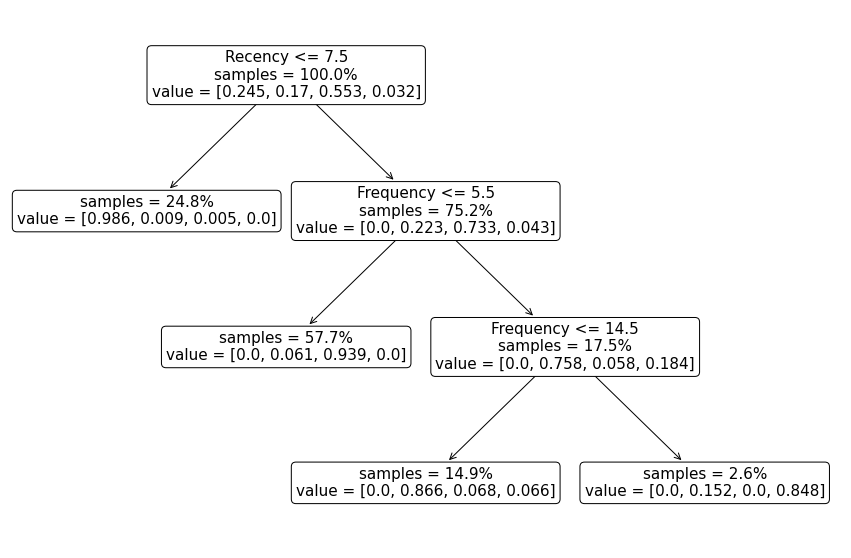

In [22]:
# Visualize the decision tree
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(clf, 
                   feature_names=['Recency', 'Frequency'], 
                   proportion=True, 
                   rounded=True, 
                   impurity=False)

### Decision Tree Clustering Result

The diagram above shows the 4 clusters based on frequency and monetary values. The same clusters are shown below in the plot.  

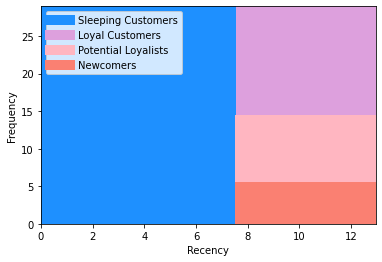

In [23]:
# Other visualization of the decision tree
plot_step = 0.05

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, colors=palette)

plt.xlabel('Recency')
plt.ylabel('Frequency')

clust_names = ["Sleeping Customers", "Loyal Customers", "Potential Loyalists", "Newcomers"]
new_palette = palette.copy()
new_palette.remove("mediumblue")

handles_lst = []
for i in range(4):
    handles_lst.append(mlines.Line2D([], [], color=new_palette[i], linewidth=10, label=clust_names[i]))

plt.legend(handles=handles_lst, loc='upper left')
plt.show()

## Interpretation 

### The analysis for 4 clusters :

We have one cluster that groups the customers with low recency score (long time no see!). These customers have often low frequency and low monetary. This is not surprising since we haven't seen them for more than 6 months. They are the *Sleeping Customers*, they left us and represent **25%**. This is huge! why did they leave? We should probably survey them!

Then the 3 other clusters are divided by frequency + cst*monetary = x. 

From high x to low x 
  
*The Loyal Customers* -> This is the cluster with the higher recency score (they came recently), the highest frequency (loyal to the store) and the higher monetary value. They represent only **3%** of customers. We should try to grow this group!
      
*Potential Loyalist* -> These customers come less often than our loyal customers, but they have still spent a great amount of money at our store. They represent **15%** of customers. The good news is that they came fairly recently. How can we encourage them to come more often? The goal here is to to convert them to loyalists.
      
*The Newcomers* -> These customers came fairly recently, but the frequency is low and they didn't have the time to spend lot of money. They represent **57%** of our customers, so it looks like we have a huge number of newcomers. How can we convert them to loyalists?
      
      